## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 5.95 MiB/s, done.
Resolving deltas: 100% (191/191), done.
/content/rapidsai-csp-utils
Branch '22.12-patch' set up to track remote branch '22.12-patch' from 'origin'.
Switched to a new branch '22.12-patch'
/content
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.4 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/env-check.py", line 26, in <module>
    gpu_name = pynvml.nvmlDeviceGetName(pynvml.nvmlDeviceGetHandleByIndex(0)).decode('UTF-8')
AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
Traceback (most recent call last):
  File "/content/rapidsai-csp-utils/colab/pip-install.py", line 26, in <module>
    gpu_name =

In [3]:
%%bash
# Install the Merlin Framework
pip install -Uq git+https://github.com/NVIDIA-Merlin/models.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/core.git@release-23.04
# pip install -Uq git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
# pip install -Uq git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
pip install -Uq git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.04
# pip install -Uq xgboost lightfm implicit

  Cloning https://github.com/NVIDIA-Merlin/models.git (to revision release-23.04) to /tmp/pip-req-build-zucjgh75
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/models.git /tmp/pip-req-build-zucjgh75
  Running command git checkout -b release-23.04 --track origin/release-23.04
  Switched to a new branch 'release-23.04'
  Branch 'release-23.04' set up to track remote branch 'release-23.04' from 'origin'.
  Resolved https://github.com/NVIDIA-Merlin/models.git to commit 56c7d6a4b2ec003472bdd176e972125632d070de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 5.3 MB/s eta 0:00:00
  Installing buil

## Load Data
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb

In [4]:
import os
import shutil
import numpy as np
from nvtabular import ops
from merlin.schema.tags import Tags
import merlin.io
import merlin.models.tf as mm

import nvtabular as nvt

from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

/usr/local/lib/python3.10/dist-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [5]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("/content/drive/MyDrive/ml-twotower-model/data/")
)

In [6]:
import glob

USE_AUGMENTED_DATASET= True
DATA_VERSION = 'v4'

_TRAIN,_VALID,_TEST = ('train_aug', 'valid_aug', 'test_aug') if USE_AUGMENTED_DATASET else ('train', 'valid', 'test')

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TRAIN + f'_{DATA_VERSION}', "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _VALID + f'_{DATA_VERSION}', "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, _TEST + f'_{DATA_VERSION}', "*.parquet")))

TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['/content/drive/MyDrive/ml-twotower-model/data/train_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/valid_aug_v4/part_0.parquet'],
 ['/content/drive/MyDrive/ml-twotower-model/data/test_aug_v4/part_0.parquet'])

In [7]:
train = merlin.io.Dataset(
    TRAIN_PATHS, engine="parquet"
)
valid = merlin.io.Dataset(
    VALID_PATHS, engine="parquet"
)

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.1

In [8]:
schema = train.schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
schema

,name,tags,dtype,is_list,is_ragged,properties.start_index,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.max_size,properties.freq_threshold,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.CATEGORICAL, Tags.ID, Tags.IT...","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,1665.0,102.0,None,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.CATEGORICAL, Tags.USER_ID, Tags.ID, Tags...","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,944.0,74.0,None,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,3.0,16.0,None,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,22.0,16.0,None,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",True,True,0.0,.//categories/unique.genres.parquet,20.0,16.0,None,0.0,0.0,0,19,genres,0.0,NaN
5,synopsis,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.synopsis.parquet,1665.0,102.0,None,0.0,0.0,0,1664,synopsis,NaN,NaN
6,title,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.title.parquet,1665.0,102.0,None,0.0,0.0,0,1664,title,NaN,NaN
7,cast,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",True,True,0.0,.//categories/unique.cast.parquet,4760.0,183.0,None,0.0,0.0,0,4759,cast,0.0,NaN


In [9]:
#sanity check
train.to_ddf().head()

,movie_id,user_id,gender,occupation,genres,rating,movie_id_raw,synopsis,title,cast
0,402,249,1,9,"[7, 2]",1.0,152,402,404,"[68, 40, 1558, 1557]"
1,546,192,1,1,"[1, 4]",1.0,581,546,542,"[166, 74, 1921, 1321]"
2,65,20,1,7,[1],1.0,196,66,68,"[34, 373, 561, 1]"
3,128,246,1,1,"[1, 2, 13]",1.0,209,128,128,"[810, 527, 181, 808, 813, 807]"
4,1648,1,2,11,[1],0.0,1566,1596,1588,"[1164, 4664]"


In [10]:
# select only trainable features and exclude the target
train.schema = schema
valid.schema = schema

In [11]:
assert len(schema.select_by_tag(Tags.TARGET).column_names) == 0

## Augment with custom pre-trained embeddings

### Load embeddings

In [23]:
FULL_DATASET = True
embedding_path = f'embeddings_train_index_{DATA_VERSION}.parquet'
movie_id_col_to_use = 'movie_id'
if FULL_DATASET:
    embedding_path = f'embeddings_full_index_{DATA_VERSION}.parquet'
    movie_id_col_to_use = 'movie_id_raw'

# embeddings = pd.read_parquet(os.path.join(DATA_DIR, f'embeddings_train_index_{DATA_VERSION}.parquet'))
embeddings = pd.read_parquet(os.path.join(DATA_DIR, embedding_path))

embeddings.shape

(1664, 3)

In [24]:
# sanity check that movie index "0" is missing
embeddings.sort_values(movie_id_col_to_use)

,movie_id_raw,title_embeddings,synopsis_embeddings
41,1,"[-0.12710177898406982, -0.3848620355129242, -0...","[-0.23947608470916748, 0.04749224707484245, 0...."
305,2,"[-0.13687774538993835, -0.20053043961524963, -...","[-0.22074897587299347, 0.022454295307397842, 0..."
72,3,"[-0.01994573324918747, -0.2046210616827011, -0...","[0.11733447015285492, 0.0836687907576561, 0.37..."
288,4,"[-0.006839410867542028, -0.3333335220813751, -...","[-0.07648835331201553, 0.1145646795630455, 0.2..."
679,5,"[-0.3565201461315155, -0.23761993646621704, -0...","[-0.0027327132411301136, -0.1977999061346054, ..."
...,...,...,...
1340,1678,"[-0.06557916104793549, -0.0035324846394360065,...","[-0.19522230327129364, 0.31564751267433167, 0...."
1339,1679,"[0.009985103271901608, -0.04608624055981636, -...","[-0.07188992202281952, -0.14516761898994446, 0..."
930,1680,"[0.14934773743152618, 0.009134497493505478, -0...","[-0.24428804218769073, -0.14837390184402466, 0..."
1619,1681,"[0.3425956070423126, -0.2802436649799347, 0.20...","[-0.2569529414176941, 0.25927525758743286, 0.1..."


In [25]:
# can be handled better with dask, but we will use pd
train_df = train.to_ddf().compute()

#### Synopsis Embeddings
- Synopsis embedding will use label encoded synopsis as lookup index

In [26]:
train_movie_id_synopsis_df = train_df[[movie_id_col_to_use, 'synopsis']].groupby([movie_id_col_to_use, 'synopsis'], as_index=False).count()
train_movie_id_synopsis_df

,movie_id_raw,synopsis
0,1,8
1,2,240
2,3,375
3,4,108
4,5,390
...,...,...
1556,1662,1506
1557,1670,1611
1558,1672,1474
1559,1676,1563


In [27]:
idx_synopsis_embeddings_df = pd.merge(train_movie_id_synopsis_df[[movie_id_col_to_use, 'synopsis']],
                                      embeddings[[movie_id_col_to_use, 'synopsis_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('synopsis').sort_index()
# sanity check synopsis=0 has no embeddings
idx_synopsis_embeddings_df

,synopsis_embeddings
synopsis,
1,"[-0.4067784249782562, -0.014127916656434536, 0..."
2,"[-0.032858122140169144, 0.09768732637166977, 0..."
3,"[0.04936177283525467, -0.06918485462665558, 0...."
4,"[-0.16613557934761047, -0.041616834700107574, ..."
5,"[-0.06875813752412796, 0.1845909059047699, 0.2..."
...,...
1643,"[-0.15503725409507751, 0.21427039802074432, 0...."
1646,"[-0.09415806829929352, -0.02912244014441967, 0..."
1647,"[-0.04749909043312073, 0.1775635927915573, 0.2..."


In [28]:
# add synopsis=0 embeddings
idx_synopsis_embeddings_df.loc[0, 'synopsis_embeddings'] = np.mean(idx_synopsis_embeddings_df['synopsis_embeddings'])
idx_synopsis_embeddings_df.sort_index(inplace=True)
idx_synopsis_embeddings_df

,synopsis_embeddings
synopsis,
0,"[-0.07616768980984934, 0.04173521747258043, 0...."
1,"[-0.4067784249782562, -0.014127916656434536, 0..."
2,"[-0.032858122140169144, 0.09768732637166977, 0..."
3,"[0.04936177283525467, -0.06918485462665558, 0...."
4,"[-0.16613557934761047, -0.041616834700107574, ..."
...,...
1643,"[-0.15503725409507751, 0.21427039802074432, 0...."
1646,"[-0.09415806829929352, -0.02912244014441967, 0..."
1647,"[-0.04749909043312073, 0.1775635927915573, 0.2..."


In [29]:
synopsis_embeddings = np.stack(idx_synopsis_embeddings_df['synopsis_embeddings'])
#sanity check
assert (synopsis_embeddings[1] == idx_synopsis_embeddings_df.loc[1, 'synopsis_embeddings']).all()

#### Title Embeddings
- Title embedding will use label encoded title as lookup index

In [30]:
train_movie_id_title_df = train_df[[movie_id_col_to_use, 'title']].groupby([movie_id_col_to_use, 'title'], as_index=False).count()
train_movie_id_title_df

,movie_id_raw,title
0,1,8
1,2,239
2,3,373
3,4,109
4,5,389
...,...,...
1556,1662,1512
1557,1670,1587
1558,1672,1501
1559,1676,1549


In [31]:
idx_title_embeddings_df = pd.merge(train_movie_id_title_df[[movie_id_col_to_use, 'title']],
                                      embeddings[[movie_id_col_to_use, 'title_embeddings']], on=movie_id_col_to_use).drop(movie_id_col_to_use, axis=1).set_index('title').sort_index()
# sanity check title=0 has no embeddings
idx_title_embeddings_df

,title_embeddings
title,
1,"[-0.09145622700452805, -0.08117646723985672, -..."
2,"[-0.043680109083652496, -0.2133939117193222, -..."
3,"[-0.06971966475248337, -0.32740920782089233, -..."
4,"[-0.10080141574144363, -0.14979368448257446, -..."
5,"[0.20293854176998138, -0.21028193831443787, -0..."
...,...
1655,"[0.10255371779203415, -0.37525221705436707, -0..."
1657,"[0.027729425579309464, -0.327641099691391, -0...."
1658,"[-0.07641997933387756, 0.022784849628806114, 0..."


In [32]:
# add title=0 embeddings
idx_title_embeddings_df.loc[0, 'title_embeddings'] = np.mean(idx_title_embeddings_df['title_embeddings'])
idx_title_embeddings_df.sort_index(inplace=True)
idx_title_embeddings_df

,title_embeddings
title,
0,"[-0.052426813907259735, -0.19883649712014173, ..."
1,"[-0.09145622700452805, -0.08117646723985672, -..."
2,"[-0.043680109083652496, -0.2133939117193222, -..."
3,"[-0.06971966475248337, -0.32740920782089233, -..."
4,"[-0.10080141574144363, -0.14979368448257446, -..."
...,...
1655,"[0.10255371779203415, -0.37525221705436707, -0..."
1657,"[0.027729425579309464, -0.327641099691391, -0...."
1658,"[-0.07641997933387756, 0.022784849628806114, 0..."


In [33]:
title_embeddings = np.stack(idx_title_embeddings_df['title_embeddings'])
#sanity check
assert (title_embeddings[1] == idx_title_embeddings_df.loc[1, 'title_embeddings']).all()

## Build Model
Reference
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/05-Retrieval-Model.ipynb
- https://github.com/NVIDIA-Merlin/models/blob/main/examples/usecases/entertainment-with-pretrained-embeddings.ipynb

### Use Custom Embedding

In [34]:
schema

,name,tags,dtype,is_list,is_ragged,properties.start_index,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.max_size,properties.freq_threshold,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.CATEGORICAL, Tags.ID, Tags.IT...","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,1665.0,102.0,None,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.CATEGORICAL, Tags.USER_ID, Tags.ID, Tags...","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,944.0,74.0,None,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,3.0,16.0,None,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,22.0,16.0,None,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",True,True,0.0,.//categories/unique.genres.parquet,20.0,16.0,None,0.0,0.0,0,19,genres,0.0,NaN
5,synopsis,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.synopsis.parquet,1665.0,102.0,None,0.0,0.0,0,1664,synopsis,NaN,NaN
6,title,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.title.parquet,1665.0,102.0,None,0.0,0.0,0,1664,title,NaN,NaN
7,cast,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",True,True,0.0,.//categories/unique.cast.parquet,4760.0,183.0,None,0.0,0.0,0,4759,cast,0.0,NaN


In [35]:
# swap synopsis embedding
schema['synopsis'].properties['embedding_sizes'] = {
    'cardinality': float(synopsis_embeddings.shape[0]),
    'dimension': float(synopsis_embeddings.shape[1])
}

# swap title embdeddings
schema['title'].properties['embedding_sizes'] = {
    'cardinality': float(title_embeddings.shape[0]),
    'dimension': float(title_embeddings.shape[1])
}

schema

,name,tags,dtype,is_list,is_ragged,properties.start_index,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.num_buckets,properties.max_size,properties.freq_threshold,properties.domain.min,properties.domain.max,properties.domain.name,properties.value_count.min,properties.value_count.max
0,movie_id,"(Tags.ITEM, Tags.CATEGORICAL, Tags.ID, Tags.IT...","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,1665.0,102.0,None,0.0,0.0,0,1664,movie_id,NaN,NaN
1,user_id,"(Tags.CATEGORICAL, Tags.USER_ID, Tags.ID, Tags...","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,944.0,74.0,None,0.0,0.0,0,943,user_id,NaN,NaN
2,gender,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,3.0,16.0,None,0.0,0.0,0,2,gender,NaN,NaN
3,occupation,"(Tags.CATEGORICAL, Tags.USER)","DType(name='int64', element_type=<ElementType....",False,False,0.0,/content/drive/MyDrive/ml-twotower-model/data/...,22.0,16.0,None,0.0,0.0,0,21,occupation,NaN,NaN
4,genres,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",True,True,0.0,.//categories/unique.genres.parquet,20.0,16.0,None,0.0,0.0,0,19,genres,0.0,NaN
5,synopsis,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.synopsis.parquet,1562.0,768.0,None,0.0,0.0,0,1664,synopsis,NaN,NaN
6,title,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",False,False,0.0,.//categories/unique.title.parquet,1562.0,768.0,None,0.0,0.0,0,1664,title,NaN,NaN
7,cast,"(Tags.CATEGORICAL, Tags.ITEM)","DType(name='int64', element_type=<ElementType....",True,True,0.0,.//categories/unique.cast.parquet,4760.0,183.0,None,0.0,0.0,0,4759,cast,0.0,NaN


In [36]:
# set schema for train and validation set
train.schema = schema
valid.schema = schema

In [37]:
embed_dims = {}
embed_dims["synopsis"] = synopsis_embeddings.shape[1]
embed_dims["title"] = title_embeddings.shape[1]

embeddings_init={
    "synopsis": mm.TensorInitializer(synopsis_embeddings),
    "title": mm.TensorInitializer(title_embeddings),
}

item_embeddings_block = mm.Embeddings(
    train.schema.select_by_tag(Tags.ITEM),
    infer_embedding_sizes=True,
    embeddings_initializer=embeddings_init,
    trainable={
        'synopsis': False,
        'title': False
        },
    dim=embed_dims,
)

### Model definition

In [38]:
import tensorflow as tf

In [39]:
def build_towers(schema=schema, tower_dim = (128, 64)):
    # create user schema using USER tag
    user_schema = schema.select_by_tag(Tags.USER)
    # create user (query) tower input block
    user_inputs = mm.InputBlockV2(user_schema)
    # create user (query) encoder block
    query = mm.Encoder(user_inputs, mm.MLPBlock(tower_dim, no_activation_last_layer=True))

    # create item schema using ITEM tag
    item_schema = schema.select_by_tag(Tags.ITEM)
    # create item (candidate) tower input block
    item_inputs = mm.InputBlockV2(item_schema, categorical=item_embeddings_block)
    # create item (candidate) encoder block
    candidate = mm.Encoder(item_inputs, mm.MLPBlock(tower_dim, no_activation_last_layer=True))

    return mm.TwoTowerModelV2(query, candidate)


In [40]:
import matplotlib.pyplot as plt
import numpy as np

default_plot_metrics = {
    'Loss': 'loss',
    'Recall@10': 'recall_at_10',
    'Ndcg@10': 'ndcg_at_10',
    'AUC': 'auc'
}

def plot_metrics(train_history, val_history, metrics=default_plot_metrics, figsize=(18, 6)):
    # Create a figure and axis
    fig, ax = plt.subplots(1, len(metrics), figsize=figsize)
    metric_map = {}

    for i, (k, m) in enumerate(metrics.items()):
        train_metric = train_history[m]
        val_metric = val_history[m]
        epochs = np.arange(1, len(train_metric) + 1)

        # Plot metric
        ax[i].plot(epochs, train_metric, label=f'Train {k}', marker='o')
        ax[i].plot(epochs, val_metric, label=f'Validation {k}', marker='o')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(k)
        ax[i].set_title(f'{k} Over Epochs')
        ax[i].legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

In [41]:
from collections import defaultdict
def merge_model_history(*history):
    _history = defaultdict(list)
    for _h in history:
        h = _h.history
        for k,v in h.items():
            _history[k].extend(v)
    return _history


In [42]:
# hack block, as Merlin top_k_encoder is broken
from merlin.models.tf.loader import Loader
from merlin.schema import ColumnSchema, Schema, Tags
def batch_predict(
        self,
        dataset: merlin.io.Dataset,
        batch_size: int,
        output_schema = None,
        index = None,
        **kwargs,
    ) -> merlin.io.Dataset:
        """Batched prediction using Dask.
        Parameters
        ----------
        dataset: merlin.io.Dataset
            Dataset to predict on.
        batch_size: int
            Batch size to use for prediction.
        Returns
        -------
        merlin.io.Dataset
        """

        if index:
            if isinstance(index, ColumnSchema):
                index = Schema([index])
            elif isinstance(index, str):
                index = Schema([self.schema[index]])
            elif isinstance(index, Tags):
                index = self.schema.select_by_tag(index)
            elif not isinstance(index, Schema):
                raise ValueError(f"Invalid index: {index}")

            if len(index) != 1:
                raise ValueError("Only one column can be used as index")
            index = index.first.name

        if hasattr(dataset, "schema"):
            if not set(self.schema.column_names).issubset(set(dataset.schema.column_names)):
                raise ValueError(
                    f"Model schema {self.schema.column_names} does not match dataset schema"
                    + f" {dataset.schema.column_names}"
                )

        # Check if merlin-dataset is passed
        if hasattr(dataset, "to_ddf"):
            # hack
            dataset = dataset.to_ddf().compute()

        from merlin.models.tf.utils.batch_utils import TFModelEncode

        model_encode = TFModelEncode(self, batch_size=batch_size, **kwargs)
        encode_kwargs = {}
        if output_schema:
            encode_kwargs["filter_input_columns"] = output_schema.column_names
        # hack
        predictions = model_encode(dataset, **encode_kwargs)
        if index:
            predictions = predictions.set_index(index)

        return merlin.io.Dataset(predictions)

from merlin.models.tf.core.encoder import TopKEncoder
def to_top_k_encoder(
        model,
        candidates: merlin.io.Dataset = None,
        candidate_id=Tags.ITEM_ID,
        strategy = "brute-force-topk",
        k: int = 10,
        batch_size = 512
):
    output_schema = model.schema.select_by_tag(candidate_id)

    # https://github.com/NVIDIA-Merlin/models/blob/stable/merlin/models/tf/models/base.py#L2479
    candidates_embeddings = batch_predict(
                model.candidate_encoder,
                candidates,
                batch_size=batch_size,
                output_schema=output_schema,
                index=candidate_id,
                output_concat_func=np.concatenate,
            )
    return TopKEncoder(
            model.query_encoder,
            topk_layer=strategy,
            k=k,
            candidates=candidates_embeddings,
            target=model.encoder._schema.select_by_tag(candidate_id).first.name,
        )

In [43]:
# Top-K evaluation
from merlin.models.utils.dataset import unique_rows_by_features
# from functools import cache


def get_candidates(data):
    candidate_features = unique_rows_by_features(data, Tags.ITEM, Tags.ITEM_ID)
    print(f'Candidate set rows:', candidate_features.num_rows)
    return candidate_features


def evaluate_model(model, ds, topk=10, batch_size=1024, item_id='movie_id'):
    candidate_features = get_candidates(ds)

    topk_model = to_top_k_encoder(model, candidate_features, k=topk, batch_size=batch_size)
    topk_model.compile(run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=[topk])
                                            ])
    eval_loader = mm.Loader(ds, batch_size=batch_size).map(mm.ToTarget(schema, item_id))
    return topk_model.evaluate(eval_loader, return_dict=True)

In [44]:
# Top-K evaluation
# BACKUP
# from merlin.models.utils.dataset import unique_rows_by_features
# from functools import cache


# def get_candidates(data):
#     candidate_features = unique_rows_by_features(train, Tags.ITEM, Tags.ITEM_ID)
#     print(candidate_features.to_ddf().compute())
#     return candidate_features

# def evaluate_model(model, ds):
#     topk = 10
#     candidate_features = get_candidates(ds)
#     topk_model = model.to_top_k_encoder(candidate_features, k=topk, batch_size=1024)

#     # we can set `metrics` param in the `compile(), if we want
#     topk_model.compile(run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
#                                              mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
#                                             ])
#     eval_loader = mm.Loader(ds, batch_size=2048).map(mm.ToTarget(schema, "movie_id"))

#     return topk_model.evaluate(eval_loader, return_dict=True)


### model_v1

In [109]:
_tower_dim = (512, 256) # @param
_learning_rate = 0.01 # @param
_batch_size = 1024 # @param
_epochs = 10 # @param
_validation_batch_size = 256 # @param


In [110]:
model_v1 = build_towers(train.schema, tower_dim=_tower_dim)
TOP_K = [100, 10]
model_v1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,
                                                            #  reduction=tf.keras.losses.Reduction.SUM # https://github.com/tensorflow/recommenders/blob/v0.7.3/tensorflow_recommenders/tasks/retrieval.py#L84
                                                             ),
)
history_v1 = []

#### model

In [128]:
_epochs = 20
history_v1.append(
    model_v1.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs, validation_batch_size=_validation_batch_size)
)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed i

Epoch 1/10
69/69 [==============================] - 6s 61ms/step - loss: 6.2156 - auc_1: 0.5938 - recall_at_100: 0.4121 - mrr_at_100: 0.0521 - ndcg_at_100: 0.1156 - map_at_100: 0.0521 - precision_at_100: 0.0041 - recall_at_10: 0.1008 - mrr_at_10: 0.0428 - ndcg_at_10: 0.0562 - map_at_10: 0.0428 - precision_at_10: 0.0101 - regularization_loss: 0.0000e+00 - loss_batch: 6.2020 - val_loss: 6.9233 - val_auc_1: 0.5546 - val_recall_at_100: 0.2379 - val_mrr_at_100: 0.0152 - val_ndcg_at_100: 0.0529 - val_map_at_100: 0.0152 - val_precision_at_100: 0.0024 - val_recall_at_10: 0.0293 - val_mrr_at_10: 0.0095 - val_ndcg_at_10: 0.0140 - val_map_at_10: 0.0095 - val_precision_at_10: 0.0029 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 6.7964
Epoch 2/10
69/69 [==============================] - 7s 62ms/step - loss: 6.2156 - auc_1: 0.5955 - recall_at_100: 0.4089 - mrr_at_100: 0.0520 - ndcg_at_100: 0.1149 - map_at_100: 0.0520 - precision_at_100: 0.0041 - recall_at_10: 0.1001 - mrr_at_10: 0.0428 - n

#### analysis

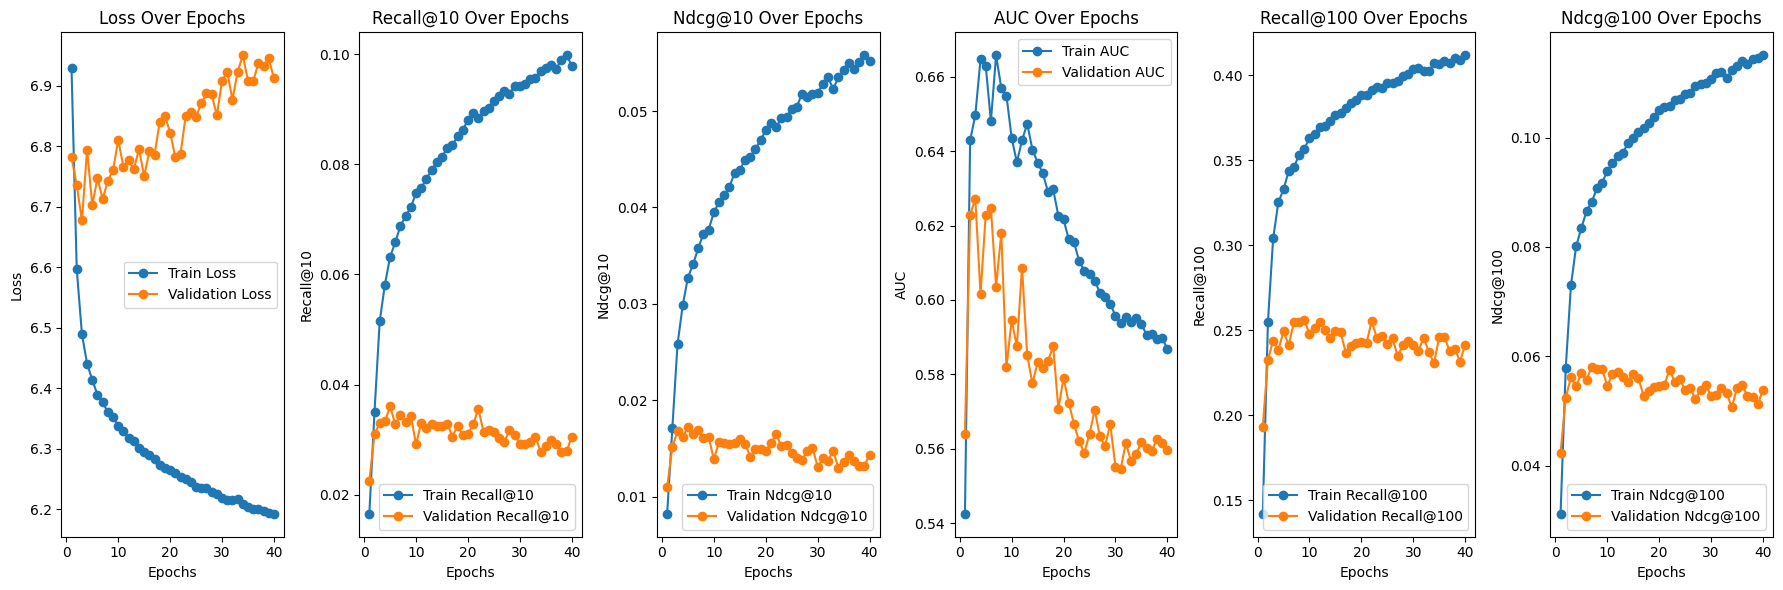

In [129]:
_history = merge_model_history(*history_v1)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': AUC_TERM, **METRIC_AT})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [130]:
(model_v1.evaluate(train, batch_size=2048, return_dict=True),
 model_v1.evaluate(valid, batch_size=2048, return_dict=True))

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(


35/35 [==============================] - 3s 41ms/step - loss: 6.8182 - auc_1: 0.5883 - recall_at_100: 0.2867 - mrr_at_100: 0.0391 - ndcg_at_100: 0.0827 - map_at_100: 0.0391 - precision_at_100: 0.0029 - recall_at_10: 0.0716 - mrr_at_10: 0.0328 - ndcg_at_10: 0.0418 - map_at_10: 0.0328 - precision_at_10: 0.0072 - regularization_loss: 0.0000e+00 - loss_batch: 6.7540


/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(


8/8 [==============================] - 1s 50ms/step - loss: 7.5880 - auc_1: 0.5569 - recall_at_100: 0.1210 - mrr_at_100: 0.0218 - ndcg_at_100: 0.0382 - map_at_100: 0.0218 - precision_at_100: 0.0012 - recall_at_10: 0.0248 - mrr_at_10: 0.0193 - ndcg_at_10: 0.0205 - map_at_10: 0.0193 - precision_at_10: 0.0025 - regularization_loss: 0.0000e+00 - loss_batch: 7.4542


({'loss': 6.818248748779297,
  'auc_1': 0.5883374214172363,
  'recall_at_100': 0.29151591658592224,
  'mrr_at_100': 0.040543332695961,
  'ndcg_at_100': 0.08475490659475327,
  'map_at_100': 0.040543332695961,
  'precision_at_100': 0.002915159100666642,
  'recall_at_10': 0.07447081059217453,
  'mrr_at_10': 0.03409094363451004,
  'ndcg_at_10': 0.04345601052045822,
  'map_at_10': 0.03409094363451004,
  'precision_at_10': 0.007447082083672285,
  'regularization_loss': 0.0,
  'loss_batch': 5.474366188049316},
 {'loss': 7.588003635406494,
  'auc_1': 0.5569407939910889,
  'recall_at_100': 0.13895948231220245,
  'mrr_at_100': 0.019466230645775795,
  'ndcg_at_100': 0.03934381902217865,
  'map_at_100': 0.019466230645775795,
  'precision_at_100': 0.0013895946322008967,
  'recall_at_10': 0.024073826149106026,
  'mrr_at_10': 0.01644575037062168,
  'ndcg_at_10': 0.018181314691901207,
  'map_at_10': 0.01644575037062168,
  'precision_at_10': 0.00240738270804286,
  'regularization_loss': 0.0,
  'loss_ba

In [131]:
evaluate_model(model_v1, train, topk=100)

Candidate set rows: 1561


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.1

69/69 [==============================] - 6s 17ms/step - loss: 1.7271 - auc_8: 0.5067 - recall_at_100: 0.3721 - mrr_at_100: 0.0278 - ndcg_at_100: 0.0870 - map_at_100: 0.0278 - precision_at_100: 0.0037 - regularization_loss: 0.0000e+00 - loss_batch: 1.7300


{'loss': 1.7270898818969727,
 'auc_8': 0.5067149996757507,
 'recall_at_100': 0.3709295988082886,
 'mrr_at_100': 0.027174249291419983,
 'ndcg_at_100': 0.08621855825185776,
 'map_at_100': 0.027174249291419983,
 'precision_at_100': 0.003709295531734824,
 'regularization_loss': 0.0,
 'loss_batch': 1.870174527168274}

In [132]:
evaluate_model(model_v1, valid, topk=100)

Candidate set rows: 1338


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.1

15/15 [==============================] - 3s 20ms/step - loss: 1.0184 - auc_9: 0.5055 - recall_at_100: 0.2015 - mrr_at_100: 0.0072 - ndcg_at_100: 0.0391 - map_at_100: 0.0072 - precision_at_100: 0.0020 - regularization_loss: 0.0000e+00 - loss_batch: 1.0692


{'loss': 1.0183708667755127,
 'auc_9': 0.5054721236228943,
 'recall_at_100': 0.2089741826057434,
 'mrr_at_100': 0.007981506176292896,
 'ndcg_at_100': 0.04101260378956795,
 'map_at_100': 0.007981506176292896,
 'precision_at_100': 0.002089741639792919,
 'regularization_loss': 0.0,
 'loss_batch': 1.600872278213501}

#### tmp

In [150]:
tf.keras.utils.plot_model(model_v1.layers, to_file='model_v1.png', show_shapes=True)

AttributeError: ignored

In [151]:
model_v1.

True

### model_v6

In [45]:
# _tower_dim = (64, 128) # @param
# _tower_dim = (128, 64) # @param
_tower_dim = (128, 64) # @param

_learning_rate = 0.01 # @param
# _batch_size = 4096 # @param
_batch_size = 1024 # @param
_epochs = 30 # @param
_validation_batch_size = 256 # @param


In [46]:
model_v6 = build_towers(train.schema, tower_dim=_tower_dim)
TOP_K = [100, 10]
model_v6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
                 run_eagerly=False, metrics=[ tf.keras.metrics.AUC(),
                                             mm.TopKMetricsAggregator.default_metrics(top_ks=TOP_K)
                                            ],
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)
history_v6 = []

#### model

In [47]:
_epochs = 30
history_v6.append(
    model_v6.fit(train, validation_data=valid, batch_size=_batch_size, epochs=_epochs, validation_batch_size=_validation_batch_size)
)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed i

InvalidArgumentError: ignored

#### analysis

In [ ]:
_history = merge_model_history(*history_v6)
AUC_TERM = [k for k in _history if k.startswith('auc')][0]
METRIC_AT = {'@'.join([k.split('_')[0].title(), k.split('_')[-1]]):k for k in _history if k.startswith('recall') or k.startswith('ndcg')}
val_history = { k[4:]:v for k,v in _history.items() if k.startswith('val')}
plot_metrics(_history, val_history, default_plot_metrics | {'AUC': AUC_TERM, **METRIC_AT})
# {'AUC': AUC_TERM, 'Recall@100': 'recall_at_100','NDCG@10': 'ndcg_at_10',}

#### eval

In [ ]:
(model_v6.evaluate(train, batch_size=2048, return_dict=True),
 model_v6.evaluate(valid, batch_size=2048, return_dict=True))

In [ ]:
evaluate_model(model_v6, train, topk=100)

In [ ]:
evaluate_model(model_v6, valid, topk=100)

### Model

In [45]:
tower_dim = 64

# create user schema using USER tag
user_schema = schema.select_by_tag(Tags.USER)
# create user (query) tower input block
user_inputs = mm.InputBlockV2(user_schema)
# create user (query) encoder block
query = mm.Encoder(user_inputs, mm.MLPBlock([128, tower_dim], no_activation_last_layer=True))

# create item schema using ITEM tag
item_schema = schema.select_by_tag(Tags.ITEM)
# create item (candidate) tower input block
item_inputs = mm.InputBlockV2(item_schema, categorical=item_embeddings_block)
# create item (candidate) encoder block
candidate = mm.Encoder(item_inputs, mm.MLPBlock([128, tower_dim], no_activation_last_layer=True))

In [46]:
model = mm.TwoTowerModelV2(query, candidate)

In [47]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=opt, run_eagerly=False, metrics=[mm.RecallAt(10), mm.NDCGAt(10), tf.keras.metrics.AUC()])
history = model.fit(train, validation_data=valid, batch_size=64, epochs=5)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed i

InvalidArgumentError: ignored

In [ ]:
history.history

{'loss': [4.157214641571045,
  4.157159805297852,
  4.157199382781982,
  4.15723180770874,
  4.157191276550293],
 'auc_5': [0.5, 0.5, 0.5, 0.5, 0.5004699230194092],
 'recall_at_10': [0.823199987411499,
  0.8248000144958496,
  0.7919999957084656,
  0.7440000176429749,
  0.7386375069618225],
 'ndcg_at_10': [0.823199987411499,
  0.8248000144958496,
  0.7919999957084656,
  0.7440000176429749,
  0.7378268837928772],
 'regularization_loss': [0.0, 0.0, 0.0, 0.0, 0.0],
 'loss_batch': [4.157838821411133,
  4.156914710998535,
  4.158390998840332,
  4.156350135803223,
  4.156854629516602],
 'val_loss': [124.23328399658203,
  83.68626403808594,
  115.26092529296875,
  133.5514678955078,
  75.48359680175781],
 'val_auc_5': [0.5000507831573486,
  0.500053882598877,
  0.5000523328781128,
  0.5000523328781128,
  0.5000022053718567],
 'val_recall_at_10': [0.9998000264167786,
  0.9986000061035156,
  1.0,
  0.9986000061035156,
  0.005100000184029341],
 'val_ndcg_at_10': [0.9007440209388733,
  0.895921945

## Evaluate the Model top-k results

In [ ]:
# Top-K evaluation
from merlin.models.utils.dataset import unique_rows_by_features

candidate_features = unique_rows_by_features(train, Tags.ITEM, Tags.ITEM_ID)
candidate_features.head()

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


,movie_id,gender,occupation,genres
0,1,1,1,"[6, 3, 8, 5, 7]"
1,45,1,3,"[2, 5]"
2,357,1,1,"[1, 5]"
3,270,1,2,[1]
4,336,1,15,[4]


In [ ]:
topk = 20
topk_model = model.to_top_k_encoder(candidate_features, k=topk, batch_size=128)

# we can set `metrics` param in the `compile(), if we want
topk_model.compile(run_eagerly=False)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(


ValueError: ignored

## TMP

In [ ]:
# model = mm.DLRMModel(
#     train.schema,
#     embedding_dim=64,
#     bottom_block=mm.MLPBlock([128, 64]),
#     top_block=mm.MLPBlock([128, 64, 32]),
#     prediction_tasks=mm.BinaryOutput(
#         train.schema.select_by_tag(Tags.TARGET).column_names[0]
#     ),
# )
# model.compile(optimizer="adam")
# model.fit(train, batch_size=1024)

In [ ]:
metrics = model.evaluate(valid, batch_size=1024, return_dict=True)

metrics